In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import time

# Image compression using clustering

In this programming assignment, you are going to apply clustering algorithms for image compression. Your
task is implementing the clustering parts with two algorithms: K-means and K-medoids. It is required
you implementing the algorithms yourself rather than calling from a package.

## K-medoids

In class, we learned that the basic K-means works in Euclidean space for computing distance between data
points as well as for updating centroids by arithmetic mean. Sometimes, however, the dataset may work
better with other distance measures. It is sometimes even impossible to compute arithmetic mean if a feature
is categorical, e.g, gender or nationality of a person. With K-medoids, you choose a representative data point
for each cluster instead of computing their average. Please note that K-medoid is different from generalized
K-means: Generalized K-means still computes centre of a cluster is not necessarily one of the input data
points (it is a point that minimizes the overall distance to all points in a cluster in a chosen distance metric).
Given m data points $x^i(i=1, ... ,m)$, K-medoids clustering algorithm groups them into K clusters by minimizing teh distortion function $J = \sum_{i=1}^m \sum_{j=1}^k r^{ij} D(x^i, \mu^j)$ where D(x,y) is a distance measure between two vectors x and y in same size (in case of K-means, D(x,y) = $||x-y||^2),\mu^j$ is the center of j-th cluster and $r^{ij}=1$ if $x^n$ belongs to the k-th cluster and $r^{ij}=0$ otherwise. In this exercise, we will use the following iterative procedure.

* Initialize the cluster center $\mu^j$, j=1, ..., k
* Iterate until convergence:
 * Update the cluster assignments for every data point $x^i : r^{ij} = 1$ if j = $argmin_j D(x^i , μ^j )$, and
$r^{ij} = 0$ otherwise.
 * Update the center for each cluster j: choosing another representative if necessary.
 
There can be many options to implement the procedure; for example, you can try many distance measures
in addition to Euclidean distance, and also you can be creative for deciding a better representative of each
cluster. We will not restrict these choices in this assignment. You are encouraged to try many distance
measures as well as way of choosing representatives (e.g., $ℓ_1$ norm).

In [9]:
class Distances:
    '''
    This class is responsible for all distance calculations. Supported distance metrics are from the set
    {eucl, eucl_squared, manhattan, minkowski}. Each method underneath calls the minkowski methods since
    each metric is a variant of the minkowski distance with respect to a different power, p.
    '''
    def __init__(self, distance: str) -> None:
        '''
        inputs
        ------
        distance (str) -> The distance metric desired from the set {eucl, eucl_squared, manhattan, minkowski}
        '''
        assert distance in ('eucl', 'eucl_squared', 'manhattan', 'minkowski'), 'Distance "{}" not understood. Please choose from ("eucl" | "eucl_squared" | "manhattan" | "minkowski")'.format(distance)
        self.distance = distance
        
    def _calculate_distance(self, p1: np.array, p2: np.array, p=None) -> np.array:
        '''
        This method is the main callable method for this class. Underneath, it will call the relevant
        distance metric as dictated by distance from class instantiation
        '''
        if self.distance == 'eucl':
            return self._euclidean(p1, p2)
        
        elif self.distance == 'eucl_squared':
            return self._euclidean(p1, p2)**2
        
        elif self.distance == 'manhattan':
            return self._manhattan(p1, p2)
        
        elif self.distance == 'minkowski' or (p>2 or p<1):
            return self._minkowski(p1, p2, p)
        
    def _euclidean(self, p1: np.array, p2:np.array) -> np.array:
        '''
        Euclidean distance
        
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        eucl: array -> euclidean distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        eucl = self._minkowski(p1, p2, 2)
        
        return eucl
    
    def _manhattan(self, p1: np.array, p2: np.array) -> np.array:
        '''
        Manhattan Distance
        
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        manhan: array -> manhattan distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        manhan = self._minkowski(p1, p2, 1)
        return manhan
    
    def _minkowski(self, p1: np.array, p2: np.array, p: int) -> np.array:
        '''
        Minkowski Distance
        
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        mink: array -> manhattan distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        mink = np.sum(np.abs(p1-p2)**p, axis=1)**(1/p)
        return mink

    
  


    
class RandomInit:
    def __init__(self, method: str)-> None:
        '''
        This class is responsible for randomly initializing centroids for either kmeans or kmedoids algorithms
        
        inputs
        ------
        method: (str) -> type of initialization need (kmedoids | kmeans)
        '''
        assert method in ('kmedoids', 'kmeans'), 'RandomInit method "{}" not understood. Please choose (kmedoids | kmeans)'.format(method)
        self.method = method
        
        
    def _initialize(self, x: np.array, k: int):
        '''
        This is the main callable method for this class to randomly intialize cluster
        centroids. Underneath it will call the proper method to initialize based off of 
        the given method during class instantiation
        '''
        if self.method == 'kmedoids' and x is None:
            raise Exception('Invalid Parameter - method chosen "kmedoids" but no data given')
        elif self.method == 'kmedoids' and k is None:
            raise Exception('Invalid Parameter - method chosen "kmedoids" but no k given')
        
        if self.method == 'kmeans' and k is None:
            raise Exception('Invalid Parameter - method chosen "kmeans" but no k given')
        elif self.method == 'kmeans' and x is None:
            raise Exception('Invalid Parameter - method chosen "kmeans" but no data given')
            
        if self.method == 'kmedoids':
            return self._kmedoids_init(x=x, k=k)
        
        elif self.method == 'kmeans':
            return self._kmeans_init(k=k, x=x)

    def _kmedoids_init(self, x: np.array, k: int)->list:
        '''
        initializes k kmedoid cluster centers by randomly selecting k data points from
        the input data
        
        inputs
        ------
        x: np.array -> The training data of shape (m,n)
        k: int -> The number of desired cluster centers
        
        outputs
        -------
        clusters: np.array -> k randomly selected data points to be the cluster centroids
        
        '''
        #holds the randomly selected data point indices
        cluster_idxs = []
        
        for i in range(k):
            #random select a datapoint index
            rand_cluster = np.random.randint(0, len(x))
            #if this point has been previously selected, select another one
            while rand_cluster in cluster_idxs:
                rand_cluster = np.random.randint(0, len(x))
            #add new data point index
            cluster_idxs.append(rand_cluster)
        #return data points located at the randomly chosen indices
        return x[cluster_idxs]
    
    def _kmeans_init(self, x: np.array, k: int) -> np.array:
        '''
        initializes k random cluster centroids by randomly selecting k values for 
        each dimension's domain in x
        
        inputs
        ------
        x: np.array -> The training data of shape (m,n)
        k: int -> the number of desired cluster centers
        
        outputs
        -------
        rand_centroids: np.array -> k randomly initialized centroids of shape (k,n)
        '''
        #get the min value for each column in x
        min_domain = np.min(x, axis=0)
        #get the max value for each column in x
        max_domain = np.max(x, axis=0)
        #get the shape of x
        m,n = x.shape
        
        #randomly generated k cluster centroids between the low and hi domains for each column
        rand_centroids = np.random.uniform(low=min_domain, high=max_domain, size=(k,n))
        
        return rand_centroids
        



        
class KMedoids:
    def __init__(self, k: int, distance_metric: str, p=None, iterations=1000, verbose=True) -> None:
        '''
        This class is the main driver for a KMedoids implementation. The initializer calls the 
        RandomInit Class and passes the proper arguments for KMedoids initialization. The distance
        metric is called from the Distances class. The distance metric is pass forward as a parameter
        to the Distance class
        '''

        self.k = k
        self.distance = Distances(distance=distance_metric)
        self.initializer = RandomInit(method='kmedoids')
        self.p = p
        self.iterations = iterations
        self.verbose = verbose
        self.converged = False
        
    def fit(self, x):
       
        m,n = x.shape
        
        #initialize empty array to hold cluster assignments
        self.cluster_assignments = np.zeros((m,1))
        
#         #initialize dict to accumulate cost for each centroid
#         self.centroid_costs = {c:0 for c in range(self.k)}
        
        #randomly initialize k clusters
        self.cluster_centers = self.initializer._initialize(x=x, k=self.k)
   
        #classify each cluster centroid point as their own cluster
        self._classify_centroids_as_themselves(x)
        
        #begin cluster assignment
        for i in range(self.iterations):
            if self.verbose:
                print('Iteration', i)
                

            
            #check if we have converged
            if self.converged:
                if self.verbose:
                    print('Converged!')
                return
            
            #assign each point to a cluster
            self._assign(x)
     
            #keep a copy of the current centroids
            old_centroids = self.cluster_centers.copy()

            #update cluster centroids
            self._update_centroids(x)
  
            #check if old_centroids are equal to new centroids - no change means we have converged
            if (old_centroids == self.cluster_centers).all():
                self.converged = True
            
            
            #reset the costs in preparation for the next cycle
            self.centroid_costs = {c:0 for c in range(self.k)}

    def _assign(self, x):

        
        #classify each data point by calculating distances
        for i in range(x.shape[0]):
            
            #isolate a single data point
            current_data_point = x[i,:].reshape(1,-1)

                
            #if data point is already a centroid then skip it
            if (current_data_point == self.cluster_centers).all(axis=1).any():
                continue
                
            #calculate the distance of the current datapoint to each centroid
            distance = self.distance._calculate_distance(current_data_point, self.cluster_centers, self.p)

            #the cluster assignment for current point is the argmin of distance
            assignment = np.argmin(distance)

            #get the cost associated with this assignment - this is located at the position of the argmin (assignment)
            cost = distance[assignment]
            
            #save assignment
            self.cluster_assignments[i] = assignment
            
#             #update the cost for the current centroid
#             self.centroid_costs[assignment] += cost

            
    def _update_centroids(self, x):
        centroid_costs = {c:np.inf for c in range(self.k)}
        
        #for each cluster
        for c in range(self.k):
            
            #get all data points that exist in cluster c
            cx = x[(self.cluster_assignments == c).ravel()]
            
            if not cx.any().any():
                idx = np.random.randint(low=0, high=x.shape[0])
                self.cluster_centers[c] = x[idx]
                
                centroid_costs[c] = np.inf
            else:
                idxs = np.random.randint(low=0, high=cx.shape[0], size=int(0.2 * len(cx)))
                current_medoid = self.cluster_centers[c]
                
                cx = np.append(cx[idxs], current_medoid.reshape(1,-1), axis=0)


                #for each point in the cluster  calculate their distance from all other points in cluster
                for pos, point in enumerate(cx):

                    #remove current point from rest of the data points in the cluster
#                     mask = np.ones((len(cx), 1))
#                     mask[(cx == point.reshape(1,-1)).all(axis=1)] = 0
#                     mask = mask.astype(bool).ravel()
#                     temp_cx = cx[mask]

                    #distance of current point from all other points
                    distance = self.distance._calculate_distance(point.reshape(1,-1), cx, self.p)
              
                    #cost is the sum of distances
                    cost = np.sum(distance)

                    #check if this cost is lower than the current cost for the centroid
                    #if it is then make this point the new centroid
                    old_cost = centroid_costs[c]
                    
                    if cost < old_cost:
                   
                        #update the cost value for this point
                        centroid_costs[c] = cost

                        #update this point as the new center for centroid c
                        self.cluster_centers[c] = point
     
    def _classify_centroids_as_themselves(self, x):
        #after random initializing centroids, need to classify these points
        #as their own cluster number
        for pos, point in enumerate(self.cluster_centers):
            idx = np.argwhere((x == point).all(axis=1))
            self.cluster_assignments[idx] = pos
                    

                
                
                
class KMeans:

    def __init__(self, k: int, distance_metric: str, p=None, iterations=1000, verbose=True) -> None:
        '''
        This class is the main driver for a KMeans implementation. The initializer calls the 
        RandomInit Class and passes the proper arguments for Kmeans initialization. The distance
        metric is called from the Distances class. The distance metric is pass forward as a parameter
        to the Distance class
        '''

        self.k = k
        self.distance = Distances(distance=distance_metric)
        self.initializer = RandomInit(method='kmeans')
        self.p = p
        self.iterations = iterations
        self.verbose = verbose
        self.converged = False
        
    def fit(self, x):
        m,n = x.shape
        
        #initialize dict to accumulate cost for each centroid
        self.centroid_costs = {c:0 for c in range(self.k)}
        
        #initialize empty array to hold cluster assignments
        self.cluster_assignments = np.zeros((m,1))
        
        #randomly initialize k clusters
        self.cluster_centers = self.initializer._initialize(x=x, k=self.k)
        
        #begin cluster assignment
        for i in range(self.iterations):
            if self.verbose:
                print('Iteration', i)
                
            #check if we have converged
            if self.converged:
                if self.verbose:
                    print('Converged!')
                return
            
            #assign each point to a cluster
            self._assign(x)
            
            #keep a copy of the current centroids
            old_centroids = self.cluster_centers.copy()

            #update cluster centroids
            self._update_centroids(x)
            
            #check if old_centroids are equal to new centroids - no change means we have converged
            if (old_centroids == self.cluster_centers).all():
                self.converged = True

            #reset the costs in preparation for the next cycle
            self.centroid_costs = {c:0 for c in range(self.k)}
            
            
            
    def _assign(self, x):
        #classify each data point by calculating distances
        for i in range(x.shape[0]):
            
            #isolate a single data point
            current_data_point = x[i,:].reshape(1,-1)
                
            #calculate the distance of the current datapoint to each centroid
            distance = self.distance._calculate_distance(current_data_point, self.cluster_centers, self.p)

            #the cluster assignment for current point is the argmin of distance
            assignment = np.argmin(distance)

            #get the cost associated with this assignment - this is located at the position of the argmin (assignment)
            cost = distance[assignment]
            
            #save assignment
            self.cluster_assignments[i] = assignment
            
            #update the cost for the current centroid
            self.centroid_costs[assignment] += cost
            
    def _update_centroids(self, x):

            #for each cluster
            for pos, c in enumerate(range(self.k)):

                #get all data points that exist in cluster c
                cx = x[(self.cluster_assignments == c).ravel()]
                
                #if a cluster has been assigned points
                if cx.any().any():
                    #calculate the positional mean
                    cluster_mean = np.mean(cx, axis=0)

                    #update the cluster centroid with the mean
                    self.cluster_centers[pos] = cluster_mean

        
        
class KMClustering:
    def __init__(self, algorithm='kmedoids', k=3, distance_metric='eucl', iterations=1000, verbose=True, p=None) -> None:
        '''
        This class is the main class for implementing either a Kmeans or Kmedoids algorithm. It is a wrapper around the base
        classes for each method so that only one API needs to be called.
        
        inputs
        ------
        algorithm: str -> Either kmedoids or kmeans
        k: int -> Number of clusters
        distance_metric: string -> Distance metric chosen from the set of {eucl | eucl_squared | manhattan | minkowski}
        iteration: int -> Number iterations the algorithm should run for
        verbose: bool -> Flag for logging to std out while training
        p: int -> Exponent desired for minkowski distance metric
        '''
        assert algorithm in ('kmedoids','kmeans'), 'Unrecognized algorithm {}. Please choose from either (kmedoids | kmeans)'.format(algorithm)
        assert isinstance(iterations, int), 'iterations must be of type int only'
        assert isinstance(verbose, bool), 'verbose parameter can only be True or False'
        
        self.algorithm = algorithm
        self.k = k
        self.distance_metric = distance_metric
        self.iterations = iterations
        self.p = p
        self.verbose = verbose
        if verbose: print(self.__repr__())
        
    def __repr__(self):
        instance = '''k: {} \nAlgorithm: {} \nDistance Metric: {} \nIterations: {} \np: {}
                   '''.format(self.k, self.algorithm, self.distance_metric, self.iterations,self.p)
        return instance
        
        
    def fit(self, x: np.array) -> None:
        
        if self.algorithm == 'kmedoids':
            self.cluster_model = KMedoids(k=self.k,
                                     distance_metric=self.distance_metric,
                                     p=self.p,
                                     iterations=self.iterations,
                                     verbose=self.verbose)
            self.cluster_model.fit(x)
            
        if self.algorithm == 'kmeans':
            self.cluster_model = KMeans(k=self.k,
                                   distance_metric=self.distance_metric,
                                   p=self.p,
                                   iterations=self.iterations,
                                   verbose=self.verbose)
            
            self.cluster_model.fit(x)
            
    def cluster_centers(self):
        return self.cluster_model.cluster_centers
    
    def clusters(self):
        return self.cluster_model.cluster_assignments.ravel()
        
        
        


In [84]:
img = plt.imread('beach.bmp')

In [4]:
import cv2

In [170]:
img = cv2.resize(img, (100,100))

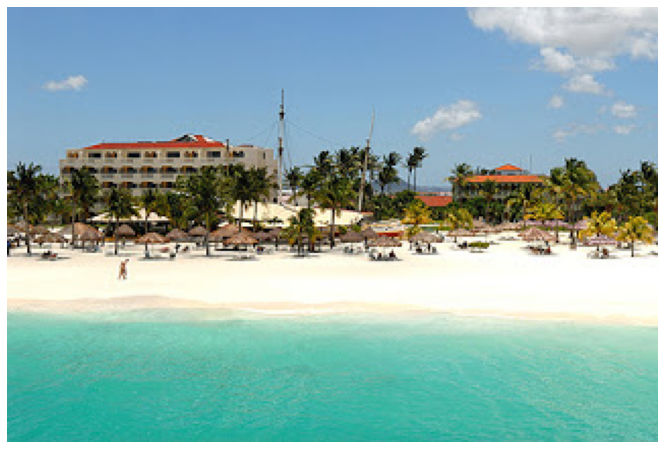

In [85]:
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [86]:
X = img.reshape(-1, 3)

In [87]:
m = KMClustering(algorithm='kmedoids', distance_metric='manhattan',k=32, iterations=10000, verbose=True)

k: 32 
Algorithm: kmedoids 
Distance Metric: manhattan 
Iterations: 10000 
p: None
                   


In [ ]:
m.fit(X)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8


In [81]:
cc = m.cluster_centers()
c = m.clusters()
temp_x = X.copy()

In [82]:
for pos, i in enumerate(cc):
    temp_x[c == pos] = i

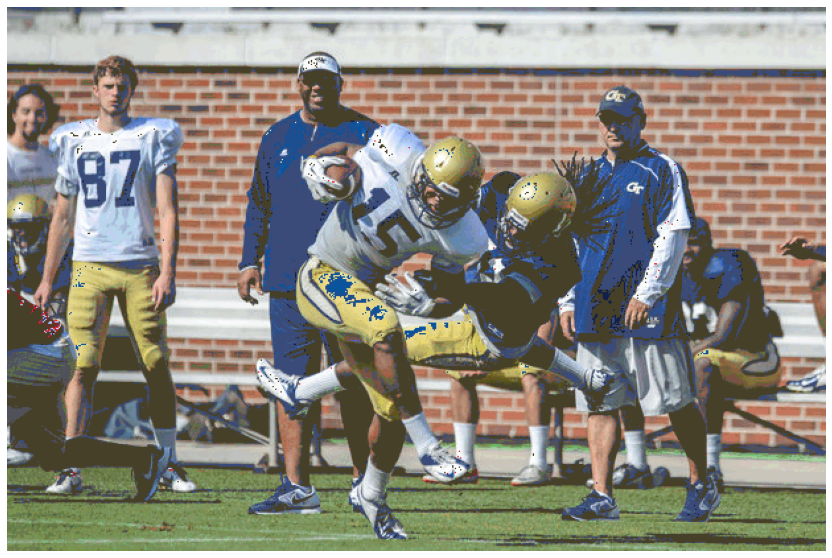

In [83]:
plt.figure(figsize=(20,10))
plt.imshow(temp_x.reshape(img.shape))
plt.axis('off')
plt.show()

In [36]:
m.cluster_centers()

array([[252, 255, 255],
       [103, 101,  89],
       [242, 246, 255],
       [202, 184, 174],
       [255, 254, 255]], dtype=uint8)

In [364]:
X.shape

(255440, 3)

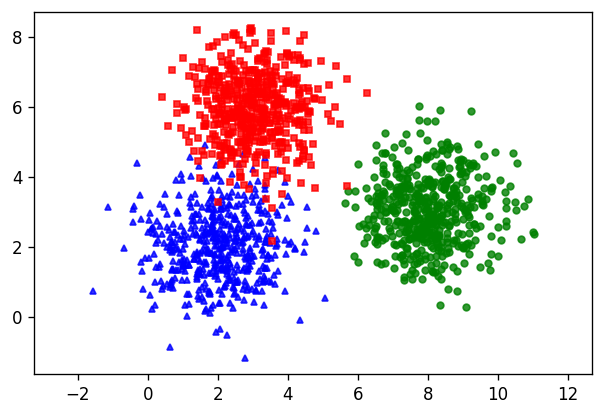

In [59]:
np.random.seed(8)

means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T


def visualize(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    
    #you can fix this dpi 
    plt.figure(dpi=120)
    
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)

    plt.axis('equal')
    plt.plot()
    plt.show()
    
visualize(X, original_label)

In [60]:
m.fit(X)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


In [61]:
m.cluster_centers()

array([[2.02955568, 1.92595694],
       [7.78977838, 3.24781126],
       [3.07559332, 6.10620812]])

In [143]:
X

array([[ 2.09120472,  3.09128273],
       [ 0.05302969,  0.61365047],
       [-0.29649157,  4.4098343 ],
       ...,
       [ 2.00597871,  5.50682198],
       [ 2.99295691,  8.15405726],
       [ 2.11716525,  4.87755525]])

In [ ]:

from sklearn_extra.cluster import KMedoids
model1 = KMedoids(n_clusters=50, random_state=0).fit(X)
print('Centers found by scikit-learn extra:')
print(model1.cluster_centers_)
pred_label = model1.predict(X)
visualize(X, pred_label)

In [278]:
np.append(a,b,axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [63]:
from sklearn import datasets
iris = datasets.load_iris()

In [64]:
X = []
X = iris.data
y = iris.target

Text(0, 0.5, 'Petal Width')

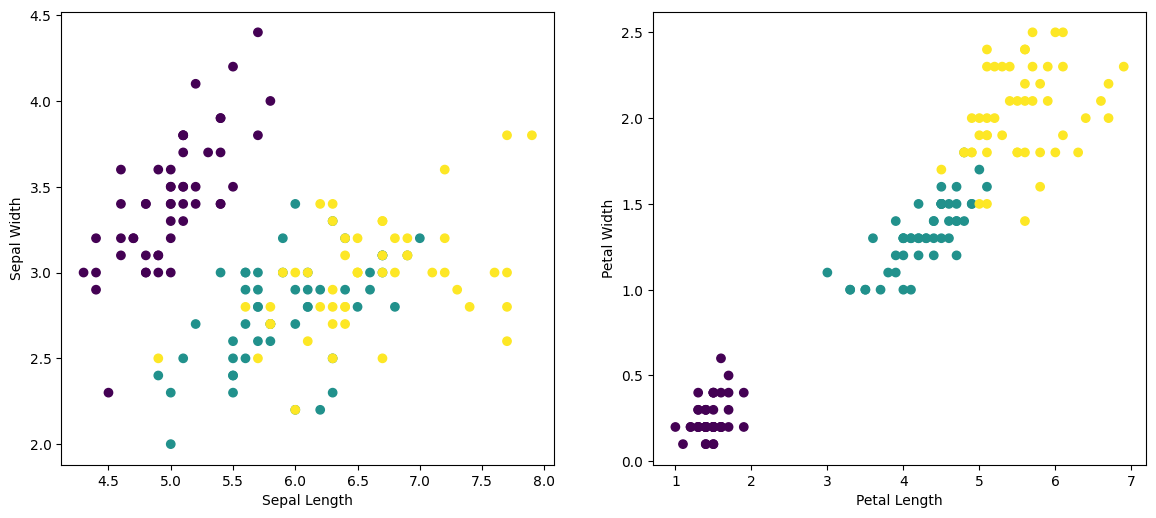

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14,6),dpi=100)
axes[0].scatter(X[:,0], X[:,1], c=y)
axes[0].set_xlabel('Sepal Length')
axes[0].set_ylabel('Sepal Width')
axes[1].scatter(X[:,2], X[:,3], c=y)
axes[1].set_xlabel('Petal Length')
axes[1].set_ylabel('Petal Width')

In [66]:
D=X[:,2:]
m.fit(D)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


In [67]:
m.cluster_centers()

array([[5.5, 1.8],
       [4. , 1.3],
       [1.5, 0.3]])

Text(0.5, 1.0, 'Predicted')

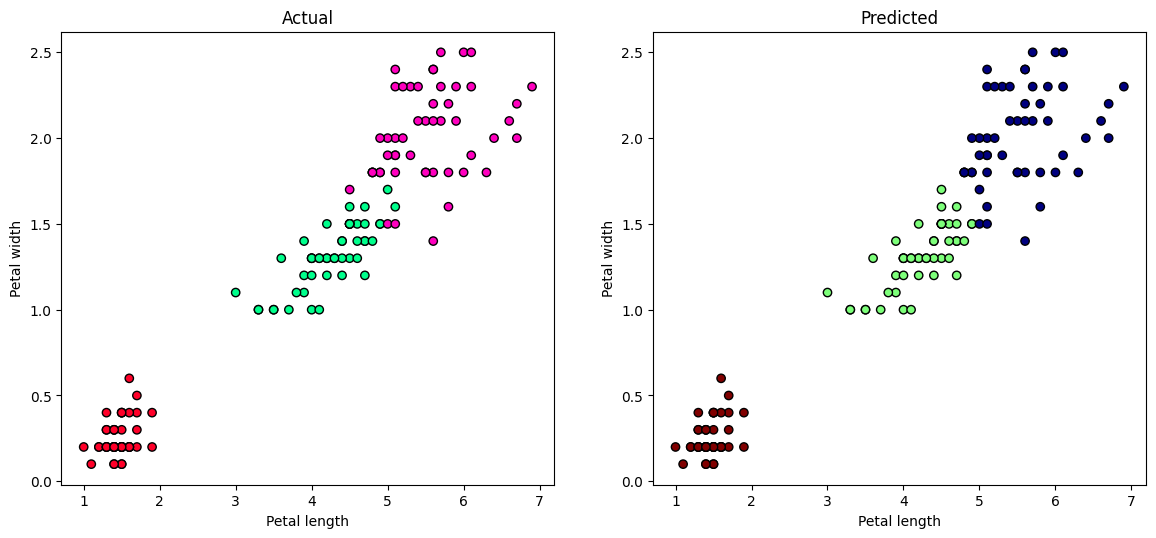

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14,6),dpi=100)
axes[0].scatter(D[:, 0], D[:, 1], c=y, cmap='gist_rainbow',
edgecolor='k')
axes[1].scatter(D[:, 0], D[:, 1], c=m.clusters(), cmap='jet',
edgecolor='k')
axes[0].set_xlabel('Petal length')
axes[0].set_ylabel('Petal width')
axes[1].set_xlabel('Petal length')
axes[1].set_ylabel('Petal width')
axes[0].set_title('Actual')
axes[1].set_title('Predicted')

In [70]:
diff = 0
for i in range(0, 3):
    count_y = 0
    count_labels = 0
    for j in range(len(y)):
        if y[j] == i:
            count_y += 1
        if m.clusters()[j] == i:
            count_labels += 1
    diff += abs(count_y - count_labels)

print("Diff = ",diff)
print("Precision of prediction = ",((len(y) - diff)/len(y))*100)

Diff =  4
Precision of prediction =  97.33333333333334
